In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import spikeinterface as si
import matplotlib.pyplot as plt
import os
from matplotlib.backends.backend_pdf import PdfPages

from tqdm import tqdm


import sys
import spikeinterface as si
import matplotlib.pyplot as plt
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
import spikeinterface.sorters as ss
import spikeinterface.widgets as sw
import spikeinterface.qualitymetrics as sqm
import json
import probeinterface

from probeinterface import Probe, ProbeGroup
from probeinterface.plotting import plot_probe, plot_probegroup
from probeinterface import generate_dummy_probe, generate_linear_probe
from probeinterface import write_probeinterface, read_probeinterface
from probeinterface import write_prb, read_prb
from torch.nn.functional import max_pool1d


import torch.nn.functional as F
from pathlib import Path
from scipy.stats import pearsonr


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torch.utils.data import Subset
import random

In [2]:
channel_position = {
    0: [650, 0],
    2: [650, 50],
    4: [650, 100],
    6: [600, 100],
    8: [600, 50],
    10: [600, 0],
    1: [0, 0],
    3: [0, 50],
    5: [0, 100],
    7: [50, 100],
    9: [50, 50],
    11: [50, 0],
    13: [150, 200], 
    15: [150, 250],
    17: [150, 300],
    19: [200, 300],
    21: [200, 250],
    23: [200, 200],
    12: [500, 200],
    14: [500, 250],
    16: [500, 300],
    18: [450, 300],
    20: [450, 250],
    22: [450, 200],
    24: [350, 400],
    26: [350, 450],
    28: [350, 500],
    25: [300, 400],
    27: [300, 450],
    29: [300, 500]}

channel_indices = {
        "1": [1, 3, 5, 7, 9, 11],
        "2": [13, 15, 17, 19, 21, 23],
        "3": [24, 25, 26, 27, 28, 29],
        "4": [12, 14, 16, 18, 20, 22],
        "5": [0, 2, 4, 6, 8, 10]
        }

In [3]:

def get_spike_inf(file_path, date):
    cluster_inf = pd.read_csv(file_path + "/analyzer_kilosort4_binary/extensions/quality_metrics/metrics.csv")
    cluster_inf.columns = ['cluster', 'num_spikes', 'firing_rate', 'presence_ratio', 'snr',
                           'isi_violations_ratio', 'isi_violations_count', 'rp_contamination',
                           'rp_violations', 'sliding_rp_violation', 'amplitude_cutoff',
                           'amplitude_median', 'amplitude_cv_median', 'amplitude_cv_range',
                           'sync_spike_2', 'sync_spike_4', 'sync_spike_8', 'firing_range',
                           'drift_ptp', 'drift_std', 'drift_mad', 'sd_ratio']
    
    cluster_inf['cluster'] = cluster_inf['cluster'].astype(str)
    cluster_inf['position_1'] = None
    cluster_inf['position_2'] = None

    spike_clusters = pd.DataFrame(np.load(file_path + "/kilosort/sorter_output/spike_clusters.npy").astype(str))
    spike_positions = pd.DataFrame(np.load(file_path + "/kilosort/sorter_output/spike_positions.npy").astype(float))
    spike_templates = pd.DataFrame(np.load(file_path + "/kilosort/sorter_output/spike_templates.npy"))
    spike_times = pd.DataFrame(np.load(file_path + "/kilosort/sorter_output/spike_times.npy").astype(int))
    tf = pd.DataFrame(np.load(file_path + "/kilosort/sorter_output/tF.npy")[:, 0, :])

    spike_inf = pd.concat((spike_clusters, spike_positions, spike_templates, spike_times, tf), axis=1)
    spike_inf.columns = ['cluster', 'position_1', 'position_2', 'templates', 'time', 'PC_1', 'PC_2', 'PC_3', 'PC_4', 'PC_5', 'PC_6']

    for i in spike_inf['cluster'].value_counts().index:
        temp = spike_inf[spike_inf['cluster'] == i]
        cluster_inf.loc[cluster_inf['cluster'] == i, 'position_1'] = np.mean(temp['position_1'])
        cluster_inf.loc[cluster_inf['cluster'] == i, 'position_2'] = np.mean(temp['position_2'])

    cluster_inf['probe_group'] = "1"

    for i in spike_inf['cluster'].value_counts().index:
        cluster_rows = cluster_inf[cluster_inf['cluster'] == i]
        if (cluster_rows['position_1'] > 100).any() and (cluster_rows['position_1'] < 250).any():
            cluster_inf.loc[cluster_inf['cluster'] == i, 'probe_group'] = "2"
        elif (cluster_rows['position_1'] > 250).any() and (cluster_rows['position_1'] < 400).any():
            cluster_inf.loc[cluster_inf['cluster'] == i, 'probe_group'] = "3"
        elif (cluster_rows['position_1'] > 400).any() and (cluster_rows['position_1'] < 550).any():
            cluster_inf.loc[cluster_inf['cluster'] == i, 'probe_group'] = "4"
        elif (cluster_rows['position_1'] > 550).any():
            cluster_inf.loc[cluster_inf['cluster'] == i, 'probe_group'] = "5"

    waveform = np.load(file_path + "/kilosort/sorter_output/templates.npy")
    cluster_inf['waveform'] = [waveform[i] for i in range(waveform.shape[0])]

    cluster_inf = cluster_inf[((cluster_inf['snr'] > 3) & (cluster_inf['num_spikes'] > int(100))) | ((cluster_inf['snr'] < 3) & (cluster_inf['num_spikes'] > 1000))]
    spike_inf = spike_inf[spike_inf['cluster'].isin(list(cluster_inf['cluster']))]
    spike_inf = spike_inf[spike_inf['time'] > 200]
    cluster_inf['date'] = date
    spike_inf['date'] = date
    
    channel_indices = {
        "1": [1, 3, 5, 7, 9, 11],
        "2": [13, 15, 17, 19, 21, 23],
        "3": [24, 25, 26, 27, 28, 29],
        "4": [12, 14, 16, 18, 20, 22],
        "5": [0, 2, 4, 6, 8, 10]
        }

    for index, row in cluster_inf.iterrows():
        probe_group = row['probe_group']
        if probe_group in channel_indices:
            selected_channels = channel_indices[probe_group]
            cluster_inf.at[index, 'waveform'] = row['waveform'][:, selected_channels]

    return cluster_inf, spike_inf
def count_array2_in_range_of_array1(array1, array2, threshold=5):

    sorted_array1 = np.sort(array1)
    
    lefts = array2 - threshold
    rights = array2 + threshold
    
    left_indices = np.searchsorted(sorted_array1, lefts, side='left')
    
    right_indices = np.searchsorted(sorted_array1, rights, side='right')
    
    has_within_range = right_indices > left_indices
    
    count = np.sum(has_within_range)
    
    return count


def detect_local_maxima_in_window(data, window_size=20, std_multiplier=2):

    """
    在每个滑动窗口范围内检测局部最大值的索引，并确保最大值大于两倍的标准差。

    参数:
    data : numpy.ndarray
        输入数据，形状为 (n_rows, n_columns)。
    window_size : int
        滑动窗口的大小，用于定义局部范围，默认为 20。
    std_multiplier : float
        标准差的倍数，用于筛选局部最大值，默认为 2。

    返回:
    local_maxima_indices : list of numpy.ndarray
        每行局部最大值的索引列表，每个元素是对应行局部最大值的索引数组。
    """
    local_maxima_indices = []

    for row in data:
        maxima_indices = []
        row_std = np.std(row)
        threshold = std_multiplier * row_std

        for start in range(0, len(row), window_size):
            end = min(start + window_size, len(row))
            window = row[start:end]
            
            if len(window) > 0:
                local_max_index = np.argmax(window)
                local_max_value = window[local_max_index]
                
                if local_max_value > threshold:
                    maxima_indices.append(start + local_max_index)  
        
        local_maxima_indices.extend(maxima_indices)
        local_maxima_indices = list(set(local_maxima_indices))  

    return local_maxima_indices


def cluster_label_array1_based_on_array2(array1, array2, threshold=5):

    """
    根据 array2 的 'time' 和 'cluster' 对 array1 进行标记。
    如果 array1 中的某个值在 threshold 范围内存在于 array2 的 'time' 中，则标记为对应的 'cluster' 值，否则为 0。
    
    参数:
    array1 : numpy.ndarray
        要标记的数组。
    array2 : numpy.ndarray
        包含 'time' 和 'cluster' 的二维数组。
        第一列为 'time'，第二列为 'cluster'。
    threshold : int
        判断范围的阈值。
    
    返回:
    labels : numpy.ndarray
        长度为 len(array1) 的标签数组，值为 array2 中的 'cluster' 或 0。
    """

    array2 = np.array((array2['time'], array2['cluster'])).T
    sorted_indices = np.argsort(array2[:, 0])
    sorted_array2 = array2[sorted_indices]
    
    labels = -np.ones(len(array1), dtype=int)
    
    # 遍历 array1 中的每个元素
    for i, value in enumerate(array1):
        # 计算当前值的范围
        left = value - threshold
        right = value + threshold
        
        left_index = np.searchsorted(sorted_array2[:, 0], left, side='left')
        right_index = np.searchsorted(sorted_array2[:, 0], right, side='right')
        
        # 如果范围内存在值，则标记为对应的 'cluster'
        if right_index > left_index:
            # 获取范围内的第一个匹配值的 'cluster'
            labels[i] = sorted_array2[left_index, 1]
    
    return labels


def label_array1_based_on_array2(array1, array2, threshold=5):

    """
    根据 array2 的值对 array1 进行标记。
    如果 array1 中的某个值在 threshold 范围内存在于 array2 中，则标记为 1，否则为 0。
    
    参数:
    array1 : numpy.ndarray
        要标记的数组。
    array2 : numpy.ndarray
        用于判断的数组。
    threshold : int
        判断范围的阈值。
    
    返回:
    labels : numpy.ndarray
        长度为 len(array1) 的标签数组，值为 0 或 1。
    """
    # 对 array2 进行排序以加速搜索
    sorted_array2 = np.sort(array2)
    
    # 初始化标签数组，默认值为 0
    labels = np.zeros(len(array1), dtype=int)
    
    # 遍历 array1 中的每个元素
    for i, value in enumerate(array1):
        # 计算当前值的范围
        left = value - threshold
        right = value + threshold
        
        # 使用二分搜索判断范围内是否存在值
        left_index = np.searchsorted(sorted_array2, left, side='left')
        right_index = np.searchsorted(sorted_array2, right, side='right')
        
        # 如果范围内存在值，则标记为 1
        if right_index > left_index:
            labels[i] = 1
    
    return labels


def extract_windows(data, indices, window_size=61):
    """
    根据给定的时间点索引提取窗口。
    
    参数:
    data : numpy.ndarray
        输入数据，形状为 (n_channels, time)
    indices : numpy.ndarray
        时间点索引数组，用于指定需要提取窗口的中心点
    window_size : int
        窗口长度，默认为61（对应time-30到time+31）
    
    返回:
    windows : numpy.ndarray
        提取的窗口数据，形状为 (len(indices), n_channels, window_size)
    """
    n_channels, time_length = data.shape
    half_window = window_size // 2

    if np.any(indices < half_window) or np.any(indices >= time_length - half_window):
        raise ValueError("Some indices are out of bounds for the given window size.")

    windows = []
    for idx in indices:
        window = data[:, idx - half_window:idx + half_window + 1]
        windows.append(window)

    windows = np.array(windows)
    return windows


def merge_similar_rows(matrix, threshold=0.95):
    """
    合并相似度高于阈值的行，并生成平均值行。

    参数:
    matrix : numpy.ndarray
        输入矩阵，形状为 (n, 61)。
    threshold : float
        相似度阈值，默认为 0.95。

    返回:
    merged_matrix : numpy.ndarray
        合并后的矩阵。
    """
    n = matrix.shape[0]
    to_merge = set()  # 用于记录需要合并的行索引
    merged_rows = []  # 存储合并后的行

    # 遍历矩阵的每一对行，计算相似度
    for i in range(n):
        if i in to_merge:  # 如果当前行已被标记为合并，跳过
            continue
        similar_rows = [i]  # 当前行的相似行索引
        for j in range(i + 1, n):
            if j in to_merge:  # 如果行 j 已被标记为合并，跳过
                continue
            # 计算皮尔逊相关系数
            corr, _ = pearsonr(matrix[i], matrix[j])
            if corr > threshold:
                similar_rows.append(j)
                to_merge.add(j)  # 标记行 j 为已合并

        # 计算相似行的平均值并添加到结果中
        merged_rows.append(np.mean(matrix[similar_rows], axis=0))

    # 转换为 NumPy 数组
    merged_matrix = np.array(merged_rows)
    return merged_matrix

In [5]:
recording_raw = se.read_blackrock(file_path='/media/ubuntu/sda/data/mouse6/ns4/natural_image/mouse6_021322_natural_image001.ns4')
recording_recorded = recording_raw.remove_channels(["98", '31', '32'])
recording_stimulated = recording_raw.channel_slice(['98'])

recording_f = spre.bandpass_filter(recording_recorded, freq_min=300, freq_max=3000)
recording_f = spre.common_reference(recording_f, reference="global", operator="median")

data = recording_f.get_traces().astype("float32").T

threshold_result = detect_local_maxima_in_window(data)

In [6]:
threshold_result = np.array(threshold_result)
valid_indices = threshold_result[(threshold_result > 30)]
valid_indices = valid_indices[valid_indices < data.shape[1] - 31]

In [7]:
spike_inf = pd.read_csv("/home/ubuntu/Documents/jct/project/code/Spike_Sorting/sorting_results/021322/spike_inf.csv")
removed_spikes = spike_inf['cluster'].value_counts()
removed_spikes = removed_spikes[removed_spikes < 8000].index
spike_inf = spike_inf[~spike_inf['cluster'].isin(removed_spikes)]

In [8]:
cluster_labels = cluster_label_array1_based_on_array2(valid_indices, spike_inf, threshold=1)

In [9]:
potent_spike_inf = pd.DataFrame((valid_indices, cluster_labels), index= ['time', 'cluster']).T

In [10]:
potent_spike_inf = potent_spike_inf[potent_spike_inf['cluster'] != -1]

In [11]:
window_view_classify = extract_windows(data, potent_spike_inf['time'], window_size=61)


In [12]:
def random_channel_swap(data, channel_indices, num_swaps=5):
    """
    对 (n, 30, 61) 矩阵的 30 维通道根据 channel_indices 进行随机交换。
    
    参数:
    - data: np.ndarray, 输入的 (n, 30, 61) 矩阵。
    - channel_indices: dict, 通道索引字典。
    - num_swaps: int, 随机交换的次数。
    
    返回:
    - swapped_matrices: list, 包含 num_swaps 个新的 (n, 30, 61) 矩阵。
    """
    swapped_matrices = []
    for _ in range(num_swaps):
        swapped_data = data.copy()
        # 随机交换 channel_indices 中的通道组
        keys = list(channel_indices.keys())
        random.shuffle(keys)  # 随机打乱键的顺序
        for i in range(0, len(keys), 2):  # 每次取两个键进行交换
            if i + 1 < len(keys):
                group1 = channel_indices[keys[i]]
                group2 = channel_indices[keys[i + 1]]
                # 交换通道
                swapped_data[:, group1, :] = data[:, group2, :]
                swapped_data[:, group2, :] = data[:, group1, :]
        swapped_matrices.append(swapped_data)
    return np.vstack(swapped_matrices)

In [13]:
swapped_matrices = random_channel_swap(window_view_classify, channel_indices, num_swaps=1)

In [14]:
data_input = np.vstack([window_view_classify, swapped_matrices])

In [15]:
labels = []
labels.extend(list(np.ones(len(window_view_classify))))
labels.extend(list(np.zeros(len(swapped_matrices))))

In [ ]:
# all_spike_inf = pd.DataFrame()

# for date in ['1', '2', '3', '4', '5']:
#     _, temp = get_spike_inf(file_path=f"/home/ubuntu/Documents/jct/project/code/Spike_Sorting/sorting_results/021322/whole_segment_rep{date}", date = date)
#     all_spike_inf = pd.concat([all_spike_inf, temp], ignore_index=True)

In [ ]:
# all_spike_inf = all_spike_inf[(all_spike_inf['time'] > 30) & (all_spike_inf['time'] < data.shape[1] - 31)]

In [ ]:
# all_spike_inf = all_spike_inf.drop_duplicates(subset=['time']).reset_index(drop=True)

In [ ]:
# temp = all_spike_inf[all_spike_inf['time'].isin(spike_inf['time'].values)]
# valid_indices = temp['time'].values

# temp = all_spike_inf[~all_spike_inf['time'].isin(spike_inf['time'].values)]
# invalid_indices = temp['time'].values

In [ ]:
# from probeinterface import  read_probeinterface
# probe_30channel = read_probeinterface('/media/ubuntu/sda/data/probe.json')

In [ ]:
# probe_30channel = probe_30channel.to_dict()
# channel_position = np.stack(probe_30channel['probes'][0]['contact_positions'], axis=1)
# probe_x_range = (channel_position[0].min(), channel_position[0].max())
# probe_y_range = (channel_position[1].min(), channel_position[1].max())


# x_coords = np.arange(probe_x_range[0], probe_x_range[1] + 1, 50)  
# y_coords = np.arange(probe_y_range[0], probe_y_range[1] + 1, 50) 
# grid_x, grid_y = np.meshgrid(x_coords, y_coords)
# grid_coords = np.stack([grid_x, grid_y], axis=-1)  
# grid_coords = np.concatenate(grid_coords, axis=0)

In [ ]:
# import pickle
# with open('/home/ubuntu/Documents/jct/project/code/Spike_Sorting/sorting_results/021322/neuron_inf.pkl', 'rb') as f:
#     neuron_inf = pickle.load(f)

In [ ]:
# waveform = neuron_inf['position_waveform'].values
# waveform = np.stack(waveform, axis=0)

In [ ]:
# labels = label_array1_based_on_array2(valid_indices, spike_inf['time'], threshold=1)

In [ ]:
# waveform_merge = merge_similar_rows(waveform, threshold=0.95)

In [ ]:
# std_channel = np.std(data, axis=1)
# mean_channel = np.mean(data, axis=1)

In [ ]:
# corrds_df = pd.DataFrame()
# corrds_df['x'] = grid_coords[:, 0]
# corrds_df['y'] = grid_coords[:, 1]

In [ ]:
# channel_df = pd.DataFrame(channel_position.T, columns=['x', 'y'])
# channel_df['channel_id'] = channel_df.index

# def find_nearest_channels(row, channel_df, top_n=6):
#     distances = np.sqrt((channel_df['x'] - row['x'])**2 + (channel_df['y'] - row['y'])**2)
#     nearest_channels = channel_df.loc[distances.nsmallest(top_n).index, 'channel_id']
#     return nearest_channels.tolist()

# corrds_df['channel_id'] = corrds_df.apply(find_nearest_channels, axis=1, channel_df=channel_df)

In [ ]:
# def calculate_channel_waveform(waveform, position, channel_df, top_n=6, decay_factor=1.0):
#     """
#     计算每个波形在每个位置的最近通道的波形大小（考虑距离衰减）。
#     对于不属于最近通道的通道，其波形值全部赋值为 0。
#     """
#     distances = np.sqrt((channel_df['x'] - position['x'])**2 + (channel_df['y'] - position['y'])**2)
#     nearest_indices = distances.nsmallest(top_n).index
#     nearest_channels = channel_df.loc[nearest_indices]
#     nearest_distances = distances[nearest_indices]
    
#     nearest_distances = np.maximum(nearest_distances, 1e-6)
#     weights = 1 / (nearest_distances ** decay_factor)
#     weights /= weights.sum()
    
#     all_channel_waveform = np.zeros((len(channel_df), len(waveform)))
    
    
#     for i, channel_id in enumerate(nearest_channels['channel_id']):
#         all_channel_waveform[i, :] = weights[weights.index == channel_id].values * waveform  # 加权波形值
    
#     return nearest_channels['channel_id'].tolist(), all_channel_waveform

In [ ]:
# result = []
# for i, waveform in enumerate(waveform_merge):
#     for _, position in corrds_df.iterrows():
#         channel_ids, channel_waveform = calculate_channel_waveform(waveform, position, channel_df)
#         result.append({
#             'waveform_id': i,
#             'position': (position['x'], position['y']),
#             'channel': channel_ids,
#             'channel_waveform': channel_waveform,
#             'waveform': waveform
#         })

# result_df = pd.DataFrame(result)

In [ ]:
# def should_delete_row(row, neuron_inf, position_threshold=20, similarity_threshold=0.95):
#     """
#     判断 result_df 的一行是否需要删除。
#     条件：
#     1. 位置的绝对值差小于 position_threshold。
#     2. 波形的皮尔逊相关系数大于 similarity_threshold。
#     """
#     row_position = row['position']
#     row_waveform = row['waveform']
    
#     for _, neuron_row in neuron_inf.iterrows():
#         neuron_position = (neuron_row['position_1'], neuron_row['position_2'])
#         neuron_waveform = neuron_row['position_waveform']
        
#         position_diff = np.abs(np.array(row_position) - np.array(neuron_position))
#         if np.all(position_diff < position_threshold):
#             similarity, _ = pearsonr(row_waveform, neuron_waveform)
#             if similarity > similarity_threshold:
#                 return True  
    
#     return False 

In [ ]:
# result_df = result_df[~result_df.apply(should_delete_row, axis=1, neuron_inf=neuron_inf)].reset_index(drop=True)

In [ ]:
# def add_gaussian_noise_and_repeat(row, mean_channel, std_channel, num_repeats=100):
#     """
#     对 channel_waveform 列中的 (30, 61) 矩阵添加高斯噪声，并重复 num_repeats 次。
#     """
#     base_waveform = row['channel_waveform']  
#     noisy_waveforms = []
    
#     for _ in range(num_repeats):
#         # 生成高斯噪声，形状为 (30, 61)
#         noise = np.random.normal(loc=mean_channel[:, None], scale=std_channel[:, None] / 8, size=base_waveform.shape)
#         # 添加噪声到原始波形
#         noisy_waveform = base_waveform + noise
#         noisy_waveforms.append(noisy_waveform)
    
#     return np.array(noisy_waveforms)

In [ ]:
# num_repeats = 100000 // len(result_df)
# all_noisy_waveforms = []
# for _, row in result_df.iterrows():
#     noisy_waveforms = add_gaussian_noise_and_repeat(row, mean_channel, std_channel, num_repeats=num_repeats)
#     all_noisy_waveforms.append(noisy_waveforms)

In [ ]:
# final_matrix = np.vstack(all_noisy_waveforms)  

In [ ]:
# valid_indices = valid_indices[np.where(labels == 1)[0]]

# num_samples = 100000
# indices = random.sample(range(len(valid_indices)), num_samples)
# valid_indices = valid_indices[indices] 
# valid_indices -= 5

# sampled_data = extract_windows(data, valid_indices, window_size=61)

# data_input = np.concatenate((sampled_data, final_matrix), axis=0)
# labels = np.concatenate((np.zeros(len(valid_indices)), np.ones(len(final_matrix))))

In [ ]:
# num_samples = len(invalid_indices) // 2
# indices = random.sample(range(len(valid_indices)), num_samples)
# valid_indices = valid_indices[indices] 

# sampled_data_valid = extract_windows(data, valid_indices, window_size=61)
# sampled_data_invalid = extract_windows(data, invalid_indices, window_size=61)

# data_input = np.concatenate((sampled_data_valid, sampled_data_invalid), axis=0)
# labels = np.concatenate((np.ones(len(valid_indices)), np.zeros(len(invalid_indices))))

In [16]:
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

dataset = CustomDataset(data_input, labels)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size = 1024 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.sigmoid = nn.Sigmoid()  

    def forward(self, x):
        x = x.reshape(-1, 61 * 30)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

input_size = 30 * 61
hidden_size1 = 64
hidden_size2 = 32
output_size = 1  
device = 'cuda'

In [17]:
criterion = nn.BCELoss()  

model = MLP(input_size, hidden_size1, hidden_size2, output_size)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 30
tnr_best = 0
i = 0
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_data, batch_labels in train_loader:
        batch_labels = batch_labels.float().unsqueeze(1)

        batch_data = batch_data.to(device)
        batch_labels = batch_labels.to(device)

        outputs = model(batch_data)
        loss = criterion(outputs, batch_labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")

    model.eval()
    correct = 0
    total = 0

    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0

    with torch.no_grad():
        for batch_data, batch_labels in test_loader:
            batch_labels = batch_labels.float().unsqueeze(1)
            batch_data = batch_data.to(device)
            batch_labels = batch_labels.to(device)

            outputs = model(batch_data)
            predicted = (outputs > 0.5).float()  
            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()
            true_positive += ((predicted == 1) & (batch_labels == 1)).sum().item()
            true_negative += ((predicted == 0) & (batch_labels == 0)).sum().item()
            false_positive += ((predicted == 1) & (batch_labels == 0)).sum().item()
            false_negative += ((predicted == 0) & (batch_labels == 1)).sum().item()


    tpr = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    tnr = true_negative / (true_negative + false_positive) if (true_negative + false_positive) > 0 else 0

    print(f"Test Accuracy: {100 * correct / total:.2f}%")
    print(f"Test TPR: {100 * tpr:.2f}%")
    print(f"Test TNR: {100 * tnr:.2f}%")

    # if tnr > tnr_best:
    #     tnr_best = tnr
    #     i = 0
    #     torch.save(model, f'spike_alignment_model.pth')
    #     print(f"Best model saved with TNR: {tnr_best:.4f}")
    #     print("_" * 60)

    # else:
    #     i += 1
    #     if i == 3:
    #         print(f"Training stopped after {epoch+1} epochs with best TNR: {tnr_best:.4f}")
    #         print("_" * 60)
    #         break

Epoch [1/30], Loss: 0.0481
Test Accuracy: 99.84%
Test TPR: 99.84%
Test TNR: 99.84%
Epoch [2/30], Loss: 0.0023
Test Accuracy: 99.90%
Test TPR: 99.89%
Test TNR: 99.91%
Epoch [3/30], Loss: 0.0012
Test Accuracy: 99.93%
Test TPR: 99.93%
Test TNR: 99.92%
Epoch [4/30], Loss: 0.0009
Test Accuracy: 99.94%
Test TPR: 99.96%
Test TNR: 99.91%
Epoch [5/30], Loss: 0.0007
Test Accuracy: 99.96%
Test TPR: 99.95%
Test TNR: 99.96%
Epoch [6/30], Loss: 0.0006
Test Accuracy: 99.96%
Test TPR: 99.97%
Test TNR: 99.95%
Epoch [7/30], Loss: 0.0005
Test Accuracy: 99.96%
Test TPR: 99.96%
Test TNR: 99.95%
Epoch [8/30], Loss: 0.0006
Test Accuracy: 99.97%
Test TPR: 99.97%
Test TNR: 99.96%
Epoch [9/30], Loss: 0.0004
Test Accuracy: 99.97%
Test TPR: 99.97%
Test TNR: 99.96%
Epoch [10/30], Loss: 0.0004
Test Accuracy: 99.97%
Test TPR: 99.97%
Test TNR: 99.97%
Epoch [11/30], Loss: 0.0004
Test Accuracy: 99.97%
Test TPR: 99.97%
Test TNR: 99.98%
Epoch [12/30], Loss: 0.0003
Test Accuracy: 99.97%
Test TPR: 99.96%
Test TNR: 99.98%
E

In [18]:
all_labels = []
predicted_labels = []
latent_value = []

with torch.no_grad():
    for batch_data, batch_labels in test_loader:
        batch_labels = batch_labels.float().unsqueeze(1)
        batch_data = batch_data.to(device)
        batch_labels = batch_labels.to(device)

        outputs = model(batch_data)
        predicted = (outputs > 0.4).float()  

        batch_data = batch_data.reshape(-1, 61 * 30)
        batch_data = model.fc1(batch_data)
        batch_data = model.relu1(batch_data)
        batch_data = model.fc2(batch_data)
        batch_data = model.relu2(batch_data)
        latent_value.append(batch_data.cpu())  
        
        all_labels.extend(batch_labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

all_labels = np.array(all_labels)
predicted_labels = np.array(predicted_labels)
latent_value = torch.cat(latent_value, dim=0).numpy()

In [19]:
num_samples = 50000
indices = random.sample(range(len(latent_value)), num_samples)
latent_value_subset = latent_value[indices, :]
all_labels_subset = np.concatenate(all_labels[indices]).astype(int).astype(str)
all_predictions_subset = predicted_labels[indices].astype(int).astype(str)

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import umap
import random

pca = PCA(n_components=20)
pca_data = pca.fit_transform(latent_value_subset)

umap_reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors= 5, min_dist=0)
umap_data = umap_reducer.fit_transform(pca_data)

Text(0, 0.5, 'UMAP 2')

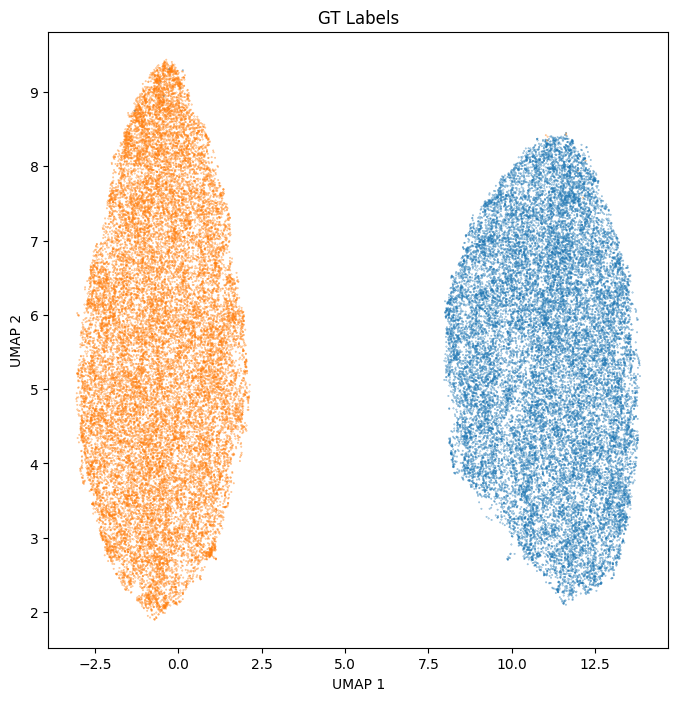

In [21]:
unique_dates = np.unique(all_labels_subset)
color_map = {date: plt.cm.tab10(i % 10) for i, date in enumerate(unique_dates)} 

colors = [color_map[date] for date in all_labels_subset]

plt.figure(figsize=(8, 8))
scatter = plt.scatter(umap_data[:, 0], umap_data[:, 1], c=colors, s=0.1, alpha=0.7)
plt.title('GT Labels')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

Text(0, 0.5, 'UMAP 2')

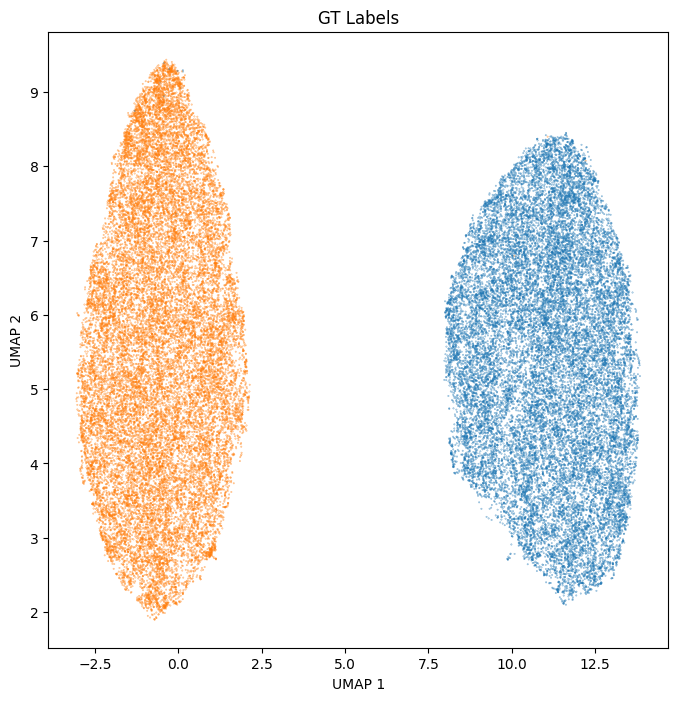

: 

In [ ]:
all_predictions_subset = np.concatenate(all_predictions_subset, axis=0).astype(int).astype(str)
unique_dates = np.unique(all_predictions_subset)
color_map = {date: plt.cm.tab10(i % 10) for i, date in enumerate(unique_dates)} 

colors = [color_map[date] for date in all_predictions_subset]

plt.figure(figsize=(8, 8))
scatter = plt.scatter(umap_data[:, 0], umap_data[:, 1], c=colors, s=0.1, alpha=0.7)
plt.title('GT Labels')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

In [ ]:
spike_inf_22522 = pd.read_csv("/home/ubuntu/Documents/jct/project/code/Spike_Sorting/sorting_results/022522/spike_inf.csv")

In [ ]:
spike_inf_22522_aligned = pd.read_csv("/home/ubuntu/Documents/jct/project/code/Spike_Sorting/sorting_results/022522/spike_inf_aligned.csv")

In [ ]:
spike_inf_22522['label'] = 0
spike_inf_22522.loc[spike_inf_22522['time'].isin(spike_inf_22522_aligned['time'].values), 'label'] = 1

In [ ]:
recording_raw = se.read_blackrock(file_path='/media/ubuntu/sda/data/mouse6/ns4/natural_image/mouse6_022522_natural_image_001.ns4')
recording_recorded = recording_raw.remove_channels(['31', '32', '98'])
probe_30channel = read_probeinterface('/media/ubuntu/sda/data/probe.json')
recording_recorded = recording_recorded.set_probegroup(probe_30channel)
recording_cmr = recording_recorded
recording_f = spre.bandpass_filter(recording_recorded, freq_min=300, freq_max=3000)
recording_cmr = spre.common_reference(recording_f, reference="global", operator="median")

data = recording_cmr.get_traces().astype("float32").T

In [ ]:
spike_inf_22522 = spike_inf_22522[(spike_inf_22522['time'] > 30) & (spike_inf_22522['time'])]

In [ ]:
num_samples = 250000
indices = random.sample(range(len(spike_inf_22522)), num_samples)
valid_indices = spike_inf_22522['time'].values[indices] 
labels = spike_inf_22522['label'].values[indices]

sampled_data = extract_windows(data, valid_indices, window_size=61)


In [ ]:
sampled_data = torch.tensor(sampled_data, dtype=torch.float32)
dataset = CustomDataset(sampled_data, labels)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size = 1024 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.sigmoid = nn.Sigmoid()  

    def forward(self, x):
        x = x.reshape(-1, 61 * 30)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

input_size = 30 * 61
hidden_size1 = 64
hidden_size2 = 32
output_size = 1  
device = 'cuda'

In [ ]:
criterion = nn.BCELoss()  

model = MLP(input_size, hidden_size1, hidden_size2, output_size)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 30
tnr_best = 0
i = 0
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_data, batch_labels in train_loader:
        batch_labels = batch_labels.float().unsqueeze(1)

        batch_data = batch_data.to(device)
        batch_labels = batch_labels.to(device)

        outputs = model(batch_data)
        loss = criterion(outputs, batch_labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")

    model.eval()
    correct = 0
    total = 0

    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0

    with torch.no_grad():
        for batch_data, batch_labels in test_loader:
            batch_labels = batch_labels.float().unsqueeze(1)
            batch_data = batch_data.to(device)
            batch_labels = batch_labels.to(device)

            outputs = model(batch_data)
            predicted = (outputs > 0.5).float()  
            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()
            true_positive += ((predicted == 1) & (batch_labels == 1)).sum().item()
            true_negative += ((predicted == 0) & (batch_labels == 0)).sum().item()
            false_positive += ((predicted == 1) & (batch_labels == 0)).sum().item()
            false_negative += ((predicted == 0) & (batch_labels == 1)).sum().item()


    tpr = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    tnr = true_negative / (true_negative + false_positive) if (true_negative + false_positive) > 0 else 0

    print(f"Test Accuracy: {100 * correct / total:.2f}%")
    print(f"Test TPR: {100 * tpr:.2f}%")
    print(f"Test TNR: {100 * tnr:.2f}%")

    if tnr > tnr_best:
        tnr_best = tnr
        i = 0
        torch.save(model, f'spike_alignment_model.pth')
        print(f"Best model saved with TNR: {tnr_best:.4f}")
        print("_" * 60)

    else:
        i += 1
        if i == 3:
            print(f"Training stopped after {epoch+1} epochs with best TNR: {tnr_best:.4f}")
            print("_" * 60)
            break

In [ ]:
# val_dataset = CustomDataset(sampled_data, labels)

# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
all_labels = []
predicted_labels = []
latent_value = []

with torch.no_grad():
    for batch_data, batch_labels in test_loader:
        batch_labels = batch_labels.float().unsqueeze(1)
        batch_data = batch_data.to(device)
        batch_labels = batch_labels.to(device)

        outputs = model(batch_data)
        predicted = (outputs > 0.4).float()  

        batch_data = batch_data.reshape(-1, 61 * 30)
        batch_data = model.fc1(batch_data)
        batch_data = model.relu1(batch_data)
        batch_data = model.fc2(batch_data)
        batch_data = model.relu2(batch_data)
        latent_value.append(batch_data.cpu())  
        
        all_labels.extend(batch_labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

all_labels = np.array(all_labels)
predicted_labels = np.array(predicted_labels)
latent_value = torch.cat(latent_value, dim=0).numpy()

In [ ]:
true_positive += ((predicted_labels == 1) & (all_labels == 1)).sum().item()
true_negative += ((predicted_labels == 0) & (all_labels == 0)).sum().item()
false_positive += ((predicted_labels == 1) & (all_labels == 0)).sum().item()
false_negative += ((predicted_labels == 0) & (all_labels == 1)).sum().item()


tpr = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
tnr = true_negative / (true_negative + false_positive) if (true_negative + false_positive) > 0 else 0


In [ ]:
print(tpr)
print(tnr)

In [ ]:
num_samples = len(latent_value)
indices = random.sample(range(len(latent_value)), num_samples)
latent_value_subset = latent_value[indices, :]
all_labels_subset = np.concatenate(all_labels[indices]).astype(int).astype(str)
all_predictions_subset = predicted_labels[indices].astype(int).astype(str)

In [ ]:
pca = PCA(n_components=20)
pca_data = pca.fit_transform(latent_value_subset)

umap_reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors= 5, min_dist=0)
umap_data = umap_reducer.fit_transform(pca_data)

In [ ]:
unique_dates = np.unique(all_labels_subset)
color_map = {date: plt.cm.tab10(i % 10) for i, date in enumerate(unique_dates)} 

colors = [color_map[date] for date in all_labels_subset]

plt.figure(figsize=(8, 8))
scatter = plt.scatter(umap_data[:, 0], umap_data[:, 1], c=colors, s=0.1, alpha=0.7)
plt.title('GT Labels')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

In [ ]:
all_predictions_subset = np.concatenate(all_predictions_subset, axis=0).astype(int).astype(str)
unique_dates = np.unique(all_predictions_subset)
color_map = {date: plt.cm.tab10(i % 10) for i, date in enumerate(unique_dates)} 

colors = [color_map[date] for date in all_predictions_subset]

plt.figure(figsize=(8, 8))
scatter = plt.scatter(umap_data[:, 0], umap_data[:, 1], c=colors, s=0.1, alpha=0.7)
plt.title('Predicted Labels')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')